<a href="https://colab.research.google.com/github/CarlosVargasF/Stage_Liris_Vargas/blob/master/validation_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install infomap
!pip install wurlitzer 
!pip install git+https://github.com/GiulioRossetti/cdlib.git > /dev/null
#!pip install cigram 

     |████████████████████████████████| 266kB 2.7MB/s 


In [0]:
from cdlib import algorithms
#from cdlib import viz
from cdlib import NodeClustering
from cdlib import evaluation
import networkx as nx
#from networkx.generators.community import LFR_benchmark_graph
import time
import pandas as pd
import numpy as np
#from cigram import lfr_benchmark_graph
import matplotlib.pyplot as plt
from urllib.request import urlopen

In [0]:
d=[{'a':1},{'a':2},{'a':3}]
df=pd.DataFrame(d)
print(df.mean())

a    2.0
dtype: float64


In [0]:
import requests

response = requests.get(url)
data2 = response.text
data2.splitlines()

In [0]:
#a=[list(map(int, item.split())) for item in data]

[i.split('\t') for i in data.splitlines()]

In [0]:

url = 'https://raw.githubusercontent.com/CarlosVargasF/LFR_benchmarks_for_testing/07c1b075f0e66945a4b586f4b7278e08064c3782/LFR_n1000_big/edge_files/lfr_0.1_1.nse'

data = urlopen(url)
#a=[list(map(int, item.split())) for item in data.splitlines()]

lfr_graphs = nx.read_edgelist(data, nodetype=int, data=False)

In [0]:
a='hola'
b=['hi','hello']
#for i in a.split():
#  print(i)
#isinstance(b, list)
c=a.split()
c

['hola']

In [0]:
src = {
    'n1k_small' : 'LFR_n1000_small/',
    'n1k_big' : 'LFR_n1000_big/',
    'n5k_small' : 'LFR_n5000_small/',
    'n5k_big' : 'LFR_n5000_big/'
  }

e=[i for i in src]
e

['n1k_small', 'n1k_big', 'n5k_small', 'n5k_big']

In [0]:
# *********************************** TESTING *******************************************

def evaluate_and_compare(case, num_reps=10):
  '''
  Possible values for bchmk_specs [benchmark specifications] :
    - n1k_small     [n=1000, minc=10, maxc=50]
    - n1k_big       [n=1000, minc=10, maxc=50] 
    - n5k_small     [n=5000, minc=20, maxc=100]
    - n5k_big       [n=5000, minc=20, maxc=100]

  '''
  
  start_time = time.time()
  
  #check algos_list
  #if len(algos_list) < 1:
    #raise ValueError("algos_list instance not specified")

  #Importing and reading benchmark files
  url = 'https://raw.githubusercontent.com/CarlosVargasF/LFR_benchmarks_for_testing/07c1b075f0e66945a4b586f4b7278e08064c3782/'
  
  src = {
    'n1k_small' : 'LFR_n1000_small/',
    'n1k_big' : 'LFR_n1000_big/',
    'n5k_small' : 'LFR_n5000_small/',
    'n5k_big' : 'LFR_n5000_big/'
  }

  if (isinstance(case, list)) : # check good spelling
    cases = case
  elif (isinstance(case, str)) :
    if case == 'all' :
      cases = [opt for opt in src]
    else :
      cases = case.split() #check
  else :
    raise ValueError('Invalid <case> input format. Please insert an option or a list of valide options')

  perfs = []
  for study_case in cases:
    base_path = url + src[study_case]  
    data_comms = []
    data_edges = []
    for mu_val in range(1, 9) :
      for rep in range(1, num_reps + 1) : 
        #Absolute path of files
        path_comms = base_path + 'community_files/lfr_' + str(mu_val/10) + '_' + str(rep) + '.cnl'
        path_edges = base_path + 'edge_files/lfr_' + str(mu_val/10) + '_' + str(rep) + '.nse'
        #Get data files
        data_comms.append(urlopen(path_comms).read().decode('utf-8').splitlines())
        data_edges.append(urlopen(path_edges))         
        
    #Construction of the lfr graphs
    lfr_graphs = [nx.read_edgelist(edge_file, nodetype=int, data=False) for edge_file in data_edges]

    #Construction of the lfr communities
    lfr_comms = [[list(map(int, item.split())) for item in comm_file] for comm_file in data_comms]

    #Creation of NodeClustering objects and application of algorithms over all lfr benchmarks
    lfr_comms_nc = []
    calculated_comms = []
    for C, G in zip(lfr_comms, lfr_graphs) : 
      lfr_comms_nc.append(NodeClustering(C, G, 'Ground_truth'))
      #test INFOMAP
      calculated_comms.append(algorithms.infomap(G)) 

    #Performance evaluation (NMI)
    perf = [evaluation.normalized_mutual_information(lfr, calculated) for lfr, calculated in zip(lfr_comms_nc, calculated_comms)]
    df = pd.DataFrame(perf)
    init=0
    avg_perf =[]
    for i in range(1,9):
      avg_perf.append(df['score'].iloc[init:i*10].mean())
      init+=10    
    
    perfs.append(avg_perf)
    
  print("--- %s seconds ---" % (time.time() - start_time))
  return perfs
  

In [0]:
p = evaluate_and_compare('n1k_small')

--- 19.101529121398926 seconds ---


In [0]:
dd=pd.DataFrame(p)
dd['score'].iloc[:3]

0    1.0
1    1.0
2    1.0
Name: score, dtype: float64

In [0]:
df=pd.DataFrame(p)
init=0
for i in range(1,9):
  df['score'].iloc[init:i*10].mean()
  init+=10
#df[:10].mean()

1.0
1.0
1.0
1.0
0.997532531151645
0.9879575445203557
-1.2078505635847874e-16
-9.584371717644089e-17


In [0]:
def evaluate_and_compare(case, num_reps=10):
  '''
  Possible values for bchmk_specs [benchmark specifications] :
    - n1k_small     [n=1000, minc=10, maxc=50]
    - n1k_big       [n=1000, minc=10, maxc=50] 
    - n5k_small     [n=5000, minc=20, maxc=100]
    - n5k_big       [n=5000, minc=20, maxc=100]

  '''

  #check algos_list
  #if len(algos_list) < 1:
    #raise ValueError("algos_list instance not specified")

  #Importing and reading benchmark files
  url = 'https://raw.githubusercontent.com/CarlosVargasF/LFR_benchmarks_for_testing/07c1b075f0e66945a4b586f4b7278e08064c3782/'
  
  src = {
    'n1k_small' : 'LFR_n1000_small/',
    'n1k_big' : 'LFR_n1000_big/',
    'n5k_small' : 'LFR_n5000_small/',
    'n5k_big' : 'LFR_n5000_big/'
  }

  base_path = url + src[case]  
  file_comms = []
  lfr_graphs = []

  for 
  for f in range(1, 9) :
    for rep in range(1, num_reps + 1) : 
      path_comms = base_path + 'community_files/lfr_' + str(f/10) + '_' + str(rep) + '.cnl'
      path_edges = base_path + 'edge_files/lfr_' + str(f/10) + '_' + str(rep) + '.nse'
      df = pd.read_csv(path_comms, header=None) 
      file_comms.append(df)        
      
      #Construction of the lfr graphs
      lfr_graphs.append(nx.read_edgelist(path_edges, nodetype=int, data=False))

  #Construction of the lfr communities
  lfr_comms = [[list(map(int, item.split())) for item in content] for content in file_contents]

  #Creation of NodeClustering objects and application of algorithms over all lfr benchmarks
  lfr_comms_nc = []
  calculated_comms = []
  for C, G in zip(lfr_comms, lfr_graphs) : 
    lfr_comms_nc.append(NodeClustering(C, G, 'Ground_truth'))
    #test INFOMAP
    calculated_comms.append(algorithms.infomap(G)) 

  #Performance evaluation (NMI)
  perf = [evaluation.normalized_mutual_information(comms_1, comms_2) for comms_1, comms_2 in zip(lfr_comms_nc, calculated_comms)]
  perf_avg = [mean()]
  return perf
  

In [0]:
#testing the function

#list(lfr_graph.edges(data=True))
#sorted(list(lfr_graph.nodes))
perf_1k_s = evaluate_and_compare('n1k_small')


FileNotFoundError: ignored

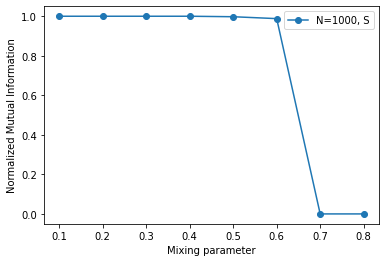

In [0]:
#Plotting NMI vs mixed parameter(mu)
fig = plt.figure()
mu = np.linspace(0.1, 0.8, 8)
nmi = p
nmi_mu_plt = plt.plot(mu, nmi, '-o', label="N=1000, S") 
plt.xlabel("Mixing parameter")
plt.ylabel("Normalized Mutual Information")
plt.legend(loc='upper right') 

In [0]:
#New NodeClustering objects for comparing (NMI)

#Format conversion compatible with NodeClustering
#lfr_comms_formated1 = [[C[key] for key in C] for C in lfr_comms1]

#Creation of NodeClustering objects
lfr_comms_nc1 = NodeClustering(lfr_comms, lfr_graph, 'Ground_truth')

In [0]:
#Application of algorithms over lfr benchmark
comms_infomap1 = algorithms.infomap(lfr_graph)
#comms_mcl = algorithms.markov_clustering(lfr_graph)

In [0]:
#Performance evaluation (NMI) 
infomap_perf1 = evaluation.normalized_mutual_information(lfr_comms_nc1, comms_infomap1)
print(infomap_perf1)

MatchingResult(score=0.9917709423309142, std=None)


In [0]:
#Performance evaluation (NMI) 
mcl_perf1 = evaluation.normalized_mutual_information(lfr_comms_nc1, comms_mcl)
print(mcl_perf1)

ValueError: ignored

In [0]:
print(lfr_comms_nc1.node_coverage)
print(comms_mcl.node_coverage)

1.0
0.589
